# Stock Prediction Model - Binary Classification

## Bài toán: Dự đoán tín hiệu MUA cổ phiếu
- **Target = 1**: Nên MUA (Future_Return_7d > 2%)
- **Target = 0**: KHÔNG MUA (Future_Return_7d ≤ 2%)

## Đặc điểm dữ liệu:
- Time series data theo từng mã cổ phiếu
- Cần chia train/test theo thời gian (không shuffle)
- Binary Classification: Tập trung vào tín hiệu MUA chất lượng cao
- Model: Random Forest & LightGBM Classifier

In [76]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [77]:
# Load data (technical indicators only, without target)
INPUT_PATH = Path("../../data/processed/ta/ta_data_technical_indicators.csv")
df = pd.read_csv(INPUT_PATH)

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Time range: {df['time'].min()} to {df['time'].max()}")
print(f"📈 Number of stocks: {df['symbol'].nunique()}")

df.head()

📊 Dataset shape: (66322, 32)
📅 Time range: 2023-01-03 00:00:00 to 2025-10-31 00:00:00
📈 Number of stocks: 100


,time,open,high,low,close,volume,symbol,price_range,price_range_pct,body_size_pct,...,volume_ratio,obv,plus_di,minus_di,adx,Volume_Spike,RSI_Oversold,RSI_Overbought,Price_Above_MA20,Price_Above_MA50
0,2023-01-03,11.28,11.28,11.00,11.19,3601,AAM,0.28,2.545455,0.797872,...,1.000000,0.0,0.000000,0.000000,NaN,0,0,0,0,0
1,2023-01-04,10.67,11.00,10.67,10.91,3900,AAM,0.33,3.092784,2.249297,...,1.039861,-3900.0,0.000000,41.250000,100.0,0,1,0,0,0
2,2023-01-05,10.44,11.19,10.44,11.19,2332,AAM,0.75,7.183908,7.183908,...,0.711482,-1568.0,0.000000,36.129032,100.0,0,0,0,1,1
3,2023-01-06,11.00,11.14,10.96,10.96,600,AAM,0.18,1.642336,0.363636,...,0.230039,-2168.0,0.000000,31.460674,100.0,0,0,0,0,0
4,2023-01-09,11.28,11.28,10.91,10.96,441,AAM,0.37,3.391384,2.836879,...,0.202777,-2168.0,6.511628,26.046512,90.0,0,0,0,0,0


In [78]:
# Sort by symbol and time to ensure correct order
df = df.sort_values(['symbol', 'time']).reset_index(drop=True)

# Calculate Future Return for each stock
def calculate_future_return(group):
    # Shift close price up by 7 days (price after 7 days)
    group['Future_Close'] = group['close'].shift(-7)
    # Calculate % return (in decimal: 0.02 = 2%)
    group['Future_Return_7d'] = (group['Future_Close'] - group['close']) / group['close']
    return group

df = df.groupby('symbol', group_keys=False).apply(calculate_future_return)

print("✅ Future_Return_7d calculated successfully.")
print(f"   Non-NaN values: {df['Future_Return_7d'].notna().sum()}")
print(f"   NaN values (last 7 days per stock): {df['Future_Return_7d'].isna().sum()}")
print(f"\n📊 Future Return statistics (decimal format):")
print(df['Future_Return_7d'].describe())

✅ Future_Return_7d calculated successfully.
   Non-NaN values: 65622
   NaN values (last 7 days per stock): 700

📊 Future Return statistics (decimal format):
count    65622.000000
mean         0.006034
std          0.070070
min         -0.495327
25%         -0.023762
50%          0.000000
75%          0.028388
max          1.119388
Name: Future_Return_7d, dtype: float64


In [79]:
# Create Binary Target variable:
# 1 = BUY (return > 2% after 7 days)
# 0 = DON'T BUY (return <= 2% after 7 days)

def classify_target(row):
    # Handle NaN Future_Return_7d (last 7 days of data)
    if pd.isna(row['Future_Return_7d']):
        return np.nan
        
    if row['Future_Return_7d'] > 0.02:  # 2% in decimal
        return 1  # BUY - High profit potential
    else:
        return 0  # DON'T BUY - Low profit or loss

df['Target'] = df.apply(classify_target, axis=1)

print("✅ Binary Target variable created successfully.")
print(f"   NaN Targets (last 7 days): {df['Target'].isna().sum()}")
print(f"\n🎯 Target distribution:")
print(df['Target'].value_counts().sort_index())
print(f"\n📋 Target distribution (%):")
print(df['Target'].value_counts(normalize=True).sort_index() * 100)

✅ Binary Target variable created successfully.
   NaN Targets (last 7 days): 700

🎯 Target distribution:
Target
0.0    45850
1.0    19772
Name: count, dtype: int64

📋 Target distribution (%):
Target
0.0    69.869861
1.0    30.130139
Name: proportion, dtype: float64


### 1.2 Create Target Variable - Future Return 7 days

In [80]:
# Feature Engineering: Thêm các chỉ báo kỹ thuật phái sinh

# 1. Volume Spike: Khối lượng tăng đột biến (> 1.5 lần trung bình)
if 'volume_ratio' in df.columns:
    df['Volume_Spike'] = (df['volume_ratio'] > 1.5).astype(int)
else:
    print("⚠️ Warning: 'volume_ratio' not found.")

# 2. RSI Signals
if 'rsi_14' in df.columns:
    df['RSI_Oversold'] = (df['rsi_14'] < 30).astype(int)
    df['RSI_Overbought'] = (df['rsi_14'] > 70).astype(int)
else:
    print("⚠️ Warning: 'rsi_14' not found.")

# 3. Price vs MA (Trend indicators)
if 'ma_20_divergence' in df.columns:
    df['Price_Above_MA20'] = (df['ma_20_divergence'] > 0).astype(int)

if 'ma_50_divergence' in df.columns:
    df['Price_Above_MA50'] = (df['ma_50_divergence'] > 0).astype(int)

print("✅ Added derived features: Volume_Spike, RSI_Signals, Price_Above_MA")

✅ Added derived features: Volume_Spike, RSI_Signals, Price_Above_MA


### 1.1 Feature Engineering - Derived Technical Indicators

## 2. Data Preparation & Feature Engineering

In [81]:
# Remove rows with NaN target (last 7 days of each stock)
df_clean = df.dropna(subset=['Target']).copy()

# Sort by symbol and time to maintain time series order
df_clean = df_clean.sort_values(['symbol', 'time']).reset_index(drop=True)

print(f"✅ Clean dataset shape: {df_clean.shape}")
print(f"❌ Removed {len(df) - len(df_clean)} rows with NaN target")
print(f"\n🎯 Target distribution after cleaning:")
print(df_clean['Target'].value_counts().sort_index())

✅ Clean dataset shape: (65622, 35)
❌ Removed 700 rows with NaN target

🎯 Target distribution after cleaning:
Target
0.0    45850
1.0    19772
Name: count, dtype: int64


In [82]:
# Define feature columns (exclude non-feature columns)
# IMPORTANT: Exclude ALL future data to prevent data leakage!
exclude_cols = ['time', 'symbol', 'Future_Return_7d', 'Future_Close', 'Target']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"📊 Number of features: {len(feature_cols)}")
print(f"\n📋 Feature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

📊 Number of features: 30

📋 Feature list:
 1. open
 2. high
 3. low
 4. close
 5. volume
 6. price_range
 7. price_range_pct
 8. body_size_pct
 9. ma_5_divergence
10. ma_20_divergence
11. ma_50_divergence
12. rsi_14
13. macd
14. macd_histogram
15. stochastic_k
16. volatility_20
17. atr_14
18. bb_width
19. bb_position
20. volume_ma_20
21. volume_ratio
22. obv
23. plus_di
24. minus_di
25. adx
26. Volume_Spike
27. RSI_Oversold
28. RSI_Overbought
29. Price_Above_MA20
30. Price_Above_MA50


## 3. Time-Series Aware Train/Test Split

**Chiến lược:** Chia theo thời gian cho từng mã cổ phiếu
- 80% dữ liệu đầu → Training set
- 20% dữ liệu cuối → Test set
- Giữ nguyên thứ tự thời gian (không shuffle)

In [83]:
def time_series_split(df, train_ratio=0.8):
    """
    Chia dữ liệu theo THỜI GIAN CHUNG cho tất cả mã cổ phiếu
    - Tìm split_date dựa trên 80% của toàn bộ time range
    - Tất cả data TRƯỚC split_date → Train
    - Tất cả data SAU split_date → Test
    - Đảm bảo KHÔNG có temporal overlap giữa train và test
    """
    # Find global time range
    min_date = df['time'].min()
    max_date = df['time'].max()
    
    # Calculate split date (80% of time range)
    time_range = (max_date - min_date).days
    split_days = int(time_range * train_ratio)
    split_date = min_date + pd.Timedelta(days=split_days)
    
    print(f"📅 Global Time Range: {min_date.date()} to {max_date.date()}")
    print(f"✂️  Split Date: {split_date.date()} ({train_ratio*100:.0f}% of time range)")
    
    # Split by time
    train_df = df[df['time'] < split_date].copy()
    test_df = df[df['time'] >= split_date].copy()
    
    return train_df, test_df

# Split data
train_df, test_df = time_series_split(df_clean, train_ratio=0.8)

print(f"\n📊 Training set: {train_df.shape}")
print(f"   Time range: {train_df['time'].min().date()} to {train_df['time'].max().date()}")
print(f"   Number of stocks: {train_df['symbol'].nunique()}")
print(f"   Target distribution:")
print(train_df['Target'].value_counts().sort_index())

print(f"\n📊 Test set: {test_df.shape}")
print(f"   Time range: {test_df['time'].min().date()} to {test_df['time'].max().date()}")
print(f"   Number of stocks: {test_df['symbol'].nunique()}")
print(f"   Target distribution:")
print(test_df['Target'].value_counts().sort_index())

# Verify NO temporal overlap
print(f"\n✅ Verification:")
print(f"   Train latest date: {train_df['time'].max().date()}")
print(f"   Test earliest date: {test_df['time'].min().date()}")
print(f"   Temporal Gap: {(test_df['time'].min() - train_df['time'].max()).days} days")
print(f"   No Overlap: {train_df['time'].max() < test_df['time'].min()}")

📅 Global Time Range: 2023-01-03 to 2025-10-22
✂️  Split Date: 2025-03-31 (80% of time range)

📊 Training set: (53469, 35)
   Time range: 2023-01-03 to 2025-03-28
   Number of stocks: 99
   Target distribution:
Target
0.0    37741
1.0    15728
Name: count, dtype: int64

📊 Test set: (12153, 35)
   Time range: 2025-03-31 to 2025-10-22
   Number of stocks: 99
   Target distribution:
Target
0.0    8109
1.0    4044
Name: count, dtype: int64

✅ Verification:
   Train latest date: 2025-03-28
   Test earliest date: 2025-03-31
   Temporal Gap: 3 days
   No Overlap: True


In [84]:
# Prepare X and y
X_train = train_df[feature_cols]
y_train = train_df['Target']

X_test = test_df[feature_cols]
y_test = test_df['Target']

# Handle missing values (fill with median)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # Use train median for test

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")
print(f"✅ y_test shape: {y_test.shape}")

# Check for remaining NaN
print(f"\n🔍 NaN values in X_train: {X_train.isna().sum().sum()}")
print(f"🔍 NaN values in X_test: {X_test.isna().sum().sum()}")

✅ X_train shape: (53469, 30)
✅ y_train shape: (53469,)
✅ X_test shape: (12153, 30)
✅ y_test shape: (12153,)

🔍 NaN values in X_train: 0
🔍 NaN values in X_test: 0


## 4. Model Training - Random Forest Classifier

In [85]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',  # Handle class imbalance
    verbose=1
)

print("🚀 Training Random Forest model...")
print(f"   Parameters: {rf_model.get_params()}\n")

# Train model
rf_model.fit(X_train, y_train)

print("✅ Training completed!")

🚀 Training Random Forest model...
   Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 1, 'warm_start': False}



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.


✅ Training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished


## 5. Model Evaluation

In [86]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate F1 scores
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')

print("="*60)
print("📊 MODEL PERFORMANCE")
print("="*60)
print(f"\n🎯 Training Set:")
print(f"   Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"   F1-Score (Macro): {train_f1_macro:.4f}")

print(f"\n🎯 Test Set:")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   F1-Score (Macro): {test_f1_macro:.4f}")
print("="*60)

📊 MODEL PERFORMANCE

🎯 Training Set:
   Accuracy: 0.8816 (88.16%)
   F1-Score (Macro): 0.8632

🎯 Test Set:
   Accuracy: 0.6039 (60.39%)
   F1-Score (Macro): 0.5581


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished


In [87]:
# Classification Report
print("\n📋 CLASSIFICATION REPORT - TEST SET")
print("="*60)
target_names = ['KHÔNG MUA (0)', 'MUA (1)']
print(classification_report(y_test, y_test_pred, target_names=target_names))


📋 CLASSIFICATION REPORT - TEST SET
               precision    recall  f1-score   support

KHÔNG MUA (0)       0.71      0.69      0.70      8109
      MUA (1)       0.41      0.42      0.42      4044

     accuracy                           0.60     12153
    macro avg       0.56      0.56      0.56     12153
 weighted avg       0.61      0.60      0.61     12153



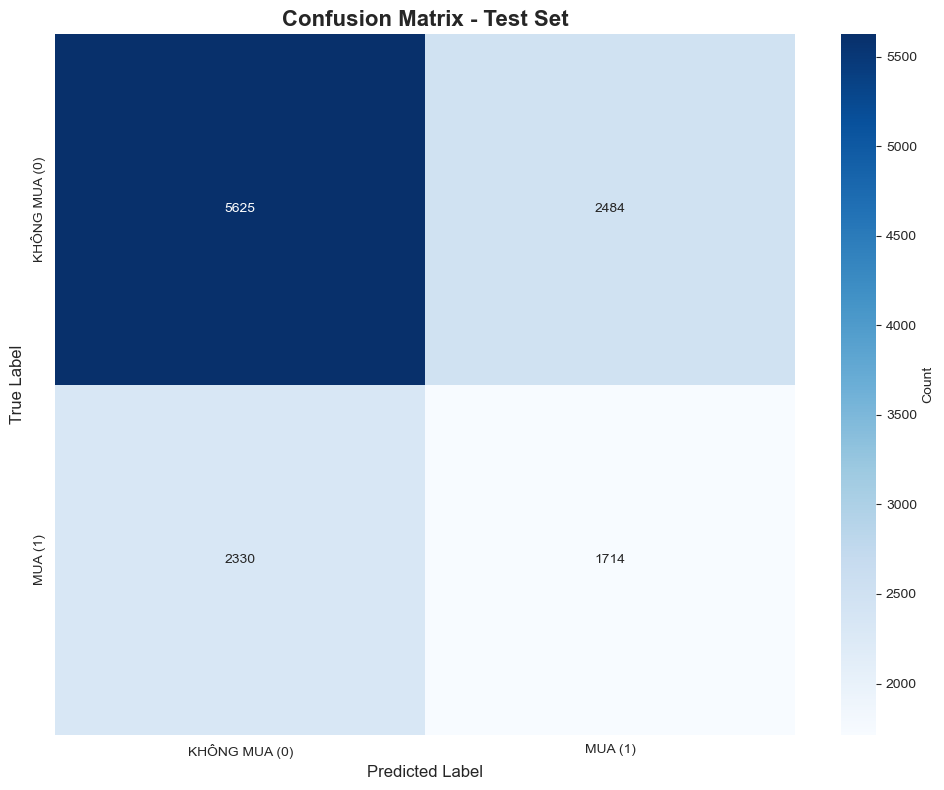


📊 Confusion Matrix (Percentages):
                   KHÔNG MUA          MUA
      KHÔNG MUA       69.37%       30.63%
            MUA       57.62%       42.38%


In [88]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['KHÔNG MUA (0)', 'MUA (1)'],
            yticklabels=['KHÔNG MUA (0)', 'MUA (1)'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate percentages
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\n📊 Confusion Matrix (Percentages):")
print(f"{'':>15} {'KHÔNG MUA':>12} {'MUA':>12}")
labels = ['KHÔNG MUA', 'MUA']
for i, label in enumerate(labels):
    print(f"{label:>15} {cm_pct[i,0]:>11.2f}% {cm_pct[i,1]:>11.2f}%")

## 6. Feature Importance Analysis

In [89]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features
top_20_features = feature_importance.head(20)

print("🔝 TOP 20 MOST IMPORTANT FEATURES:")
print("="*60)
for idx, row in top_20_features.iterrows():
    print(f"{row['feature']:30s} {row['importance']:.4f}")
print("="*60)

🔝 TOP 20 MOST IMPORTANT FEATURES:
volatility_20                  0.0740
volume_ma_20                   0.0611
obv                            0.0600
bb_width                       0.0581
atr_14                         0.0454
ma_20_divergence               0.0439
ma_50_divergence               0.0435
macd                           0.0427
adx                            0.0427
macd_histogram                 0.0405
ma_5_divergence                0.0400
close                          0.0399
high                           0.0396
low                            0.0377
minus_di                       0.0376
open                           0.0376
volume                         0.0370
plus_di                        0.0363
stochastic_k                   0.0318
bb_position                    0.0288


---

## 7. Baseline Model - Logistic Regression

Model đơn giản để làm baseline so sánh với Random Forest và LightGBM

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Logistic Regression requires feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("🚀 Training Logistic Regression (Baseline) model...")
print(f"   Parameters: max_iter={lr_model.max_iter}, class_weight={lr_model.class_weight}\n")

# Train model
lr_model.fit(X_train_scaled, y_train)

print("✅ Baseline training completed!")

🚀 Training Logistic Regression (Baseline) model...
   Parameters: max_iter=1000, class_weight=balanced

✅ Baseline training completed!


In [91]:
# Make predictions with Logistic Regression
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Calculate metrics
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)

train_f1_macro_lr = f1_score(y_train, y_train_pred_lr, average='macro')
test_f1_macro_lr = f1_score(y_test, y_test_pred_lr, average='macro')

print("="*60)
print("📊 LOGISTIC REGRESSION (BASELINE) PERFORMANCE")
print("="*60)
print(f"\n🎯 Training Set:")
print(f"   Accuracy: {train_accuracy_lr:.4f} ({train_accuracy_lr*100:.2f}%)")
print(f"   F1-Score (Macro): {train_f1_macro_lr:.4f}")

print(f"\n🎯 Test Set:")
print(f"   Accuracy: {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")
print(f"   F1-Score (Macro): {test_f1_macro_lr:.4f}")
print("="*60)

📊 LOGISTIC REGRESSION (BASELINE) PERFORMANCE

🎯 Training Set:
   Accuracy: 0.6025 (60.25%)
   F1-Score (Macro): 0.5635

🎯 Test Set:
   Accuracy: 0.5835 (58.35%)
   F1-Score (Macro): 0.5668


In [92]:
# Classification Report for Logistic Regression
print("\n📋 CLASSIFICATION REPORT - BASELINE TEST SET")
print("="*60)
target_names = ['KHÔNG MUA (0)', 'MUA (1)']
print(classification_report(y_test, y_test_pred_lr, target_names=target_names))


📋 CLASSIFICATION REPORT - BASELINE TEST SET
               precision    recall  f1-score   support

KHÔNG MUA (0)       0.74      0.58      0.65      8109
      MUA (1)       0.41      0.58      0.48      4044

     accuracy                           0.58     12153
    macro avg       0.57      0.58      0.57     12153
 weighted avg       0.63      0.58      0.60     12153



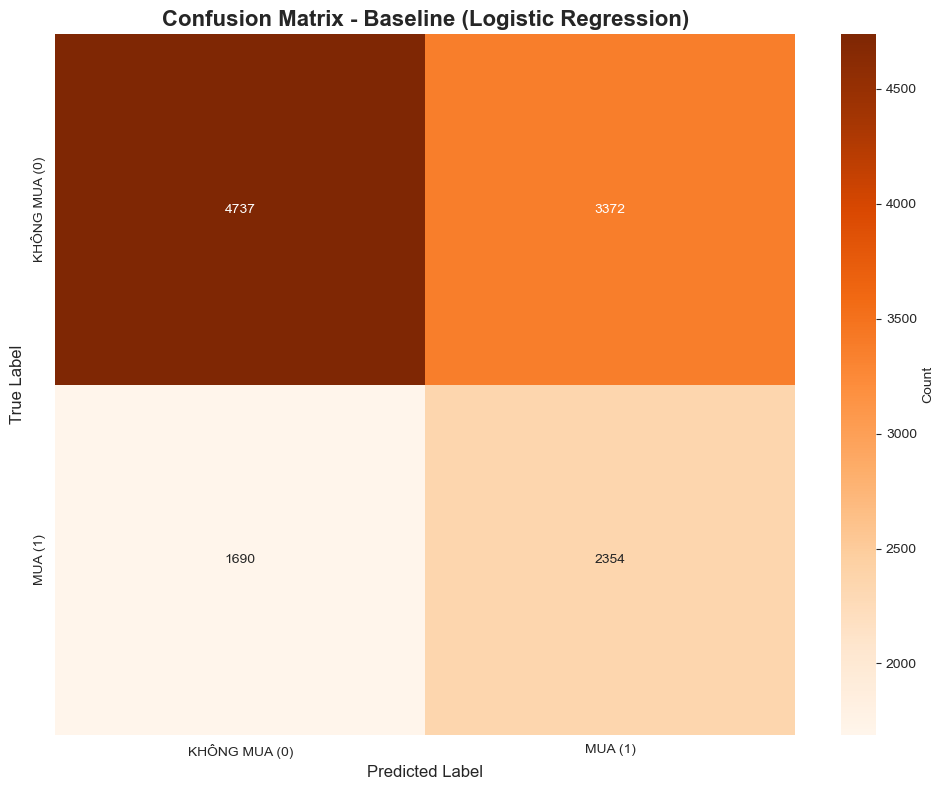


📊 Confusion Matrix (Percentages):
                   KHÔNG MUA          MUA
      KHÔNG MUA       58.42%       41.58%
            MUA       41.79%       58.21%


In [93]:
# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_test_pred_lr)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['KHÔNG MUA (0)', 'MUA (1)'],
            yticklabels=['KHÔNG MUA (0)', 'MUA (1)'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Baseline (Logistic Regression)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate percentages
cm_lr_pct = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis] * 100
print("\n📊 Confusion Matrix (Percentages):")
print(f"{'':>15} {'KHÔNG MUA':>12} {'MUA':>12}")
labels = ['KHÔNG MUA', 'MUA']
for i, label in enumerate(labels):
    print(f"{label:>15} {cm_lr_pct[i,0]:>11.2f}% {cm_lr_pct[i,1]:>11.2f}%")

## 7. Prediction Examples - Per Stock Analysis

In [94]:
# Add predictions to test dataframe
test_df_with_pred = test_df.copy()
test_df_with_pred['Predicted'] = y_test_pred
test_df_with_pred['Correct'] = (test_df_with_pred['Target'] == test_df_with_pred['Predicted'])

# Sample predictions for first 3 stocks
sample_stocks = test_df_with_pred['symbol'].unique()[:3]

print("📊 SAMPLE PREDICTIONS FOR FIRST 3 STOCKS")
print("="*80)

for stock in sample_stocks:
    stock_data = test_df_with_pred[test_df_with_pred['symbol'] == stock].tail(10)
    
    print(f"\n🏢 Stock: {stock}")
    print(f"   Accuracy: {stock_data['Correct'].mean()*100:.2f}%")
    print(f"   {'Date':<12} {'Actual':<10} {'Predicted':<10} {'Correct'}")
    print("   " + "-"*50)
    
    for _, row in stock_data.iterrows():
        action_map = {-1: 'SELL', 0: 'HOLD', 1: 'BUY'}
        actual = action_map[row['Target']]
        pred = action_map[row['Predicted']]
        correct = '✅' if row['Correct'] else '❌'
        print(f"   {row['time'].strftime('%Y-%m-%d'):<12} {actual:<10} {pred:<10} {correct}")

print("="*80)

📊 SAMPLE PREDICTIONS FOR FIRST 3 STOCKS

🏢 Stock: AAM
   Accuracy: 100.00%
   Date         Actual     Predicted  Correct
   --------------------------------------------------
   2025-10-09   HOLD       HOLD       ✅
   2025-10-10   HOLD       HOLD       ✅
   2025-10-13   HOLD       HOLD       ✅
   2025-10-14   HOLD       HOLD       ✅
   2025-10-15   HOLD       HOLD       ✅
   2025-10-16   HOLD       HOLD       ✅
   2025-10-17   HOLD       HOLD       ✅
   2025-10-20   HOLD       HOLD       ✅
   2025-10-21   HOLD       HOLD       ✅
   2025-10-22   HOLD       HOLD       ✅

🏢 Stock: ACV
   Accuracy: 60.00%
   Date         Actual     Predicted  Correct
   --------------------------------------------------
   2025-10-09   HOLD       HOLD       ✅
   2025-10-10   HOLD       HOLD       ✅
   2025-10-13   HOLD       HOLD       ✅
   2025-10-14   HOLD       HOLD       ✅
   2025-10-15   HOLD       BUY        ❌
   2025-10-16   HOLD       BUY        ❌
   2025-10-17   BUY        BUY        ✅
   2025-10-

## 8. Model Summary & Insights

In [95]:
print("="*80)
print("📊 FINAL MODEL SUMMARY")
print("="*80)
print(f"\n🤖 Model: Random Forest Classifier")
print(f"   - Number of trees: {rf_model.n_estimators}")
print(f"   - Max depth: {rf_model.max_depth}")
print(f"   - Class weight: {rf_model.class_weight}")

print(f"\n📈 Dataset:")
print(f"   - Training samples: {len(X_train):,}")
print(f"   - Test samples: {len(X_test):,}")
print(f"   - Number of features: {len(feature_cols)}")
print(f"   - Number of stocks: {df_clean['symbol'].nunique()}")

print(f"\n🎯 Performance:")
print(f"   - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   - Test F1-Score (Macro): {test_f1_macro:.4f}")

print(f"\n🔝 Top 5 Most Important Features:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n💡 Insights:")
print(f"   - Model sử dụng time-series split (80/20)")
print(f"   - Không shuffle để giữ tính time series")
print(f"   - Class weight balanced để xử lý imbalanced data")
print(f"   - Prediction được thực hiện cho 20% dữ liệu cuối của mỗi mã")

print("="*80)

📊 FINAL MODEL SUMMARY

🤖 Model: Random Forest Classifier
   - Number of trees: 100
   - Max depth: 15
   - Class weight: balanced

📈 Dataset:
   - Training samples: 53,469
   - Test samples: 12,153
   - Number of features: 30
   - Number of stocks: 100

🎯 Performance:
   - Test Accuracy: 0.6039 (60.39%)
   - Test F1-Score (Macro): 0.5581

🔝 Top 5 Most Important Features:
   16. volatility_20: 0.0740
   20. volume_ma_20: 0.0611
   22. obv: 0.0600
   18. bb_width: 0.0581
   17. atr_14: 0.0454

💡 Insights:
   - Model sử dụng time-series split (80/20)
   - Không shuffle để giữ tính time series
   - Class weight balanced để xử lý imbalanced data
   - Prediction được thực hiện cho 20% dữ liệu cuối của mỗi mã


---

## 9. LightGBM Model - Comparison

LightGBM thường cho hiệu suất tốt hơn với time series và large datasets

In [96]:
# Initialize LightGBM Classifier
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=-1
)

print("🚀 Training LightGBM model...")
print(f"   Parameters:")
print(f"   - n_estimators: {lgbm_model.n_estimators}")
print(f"   - max_depth: {lgbm_model.max_depth}")
print(f"   - learning_rate: {lgbm_model.learning_rate}")
print(f"   - num_leaves: {lgbm_model.num_leaves}\n")

# Train model
lgbm_model.fit(X_train, y_train)

print("✅ LightGBM training completed!")

🚀 Training LightGBM model...
   Parameters:
   - n_estimators: 200
   - max_depth: 10
   - learning_rate: 0.05
   - num_leaves: 31



✅ LightGBM training completed!


In [97]:
# Get LightGBM feature importances
feature_importance_lgbm = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features
top_20_features_lgbm = feature_importance_lgbm.head(20)

print("🔝 TOP 20 MOST IMPORTANT FEATURES - LIGHTGBM:")
print("="*60)
for idx, row in top_20_features_lgbm.iterrows():
    print(f"{row['feature']:30s} {row['importance']:.4f}")
print("="*60)

🔝 TOP 20 MOST IMPORTANT FEATURES - LIGHTGBM:
obv                            594.0000
volume_ma_20                   532.0000
volatility_20                  484.0000
atr_14                         366.0000
adx                            362.0000
macd                           335.0000
ma_50_divergence               321.0000
bb_width                       287.0000
macd_histogram                 261.0000
minus_di                       250.0000
close                          247.0000
plus_di                        240.0000
open                           205.0000
low                            188.0000
high                           182.0000
stochastic_k                   181.0000
volume                         154.0000
ma_20_divergence               151.0000
rsi_14                         138.0000
ma_5_divergence                135.0000


In [98]:
# Make predictions with LightGBM
y_train_pred_lgbm = lgbm_model.predict(X_train)
y_test_pred_lgbm = lgbm_model.predict(X_test)

# Calculate metrics
train_accuracy_lgbm = accuracy_score(y_train, y_train_pred_lgbm)
test_accuracy_lgbm = accuracy_score(y_test, y_test_pred_lgbm)

train_f1_macro_lgbm = f1_score(y_train, y_train_pred_lgbm, average='macro')
test_f1_macro_lgbm = f1_score(y_test, y_test_pred_lgbm, average='macro')

print("="*60)
print("📊 LIGHTGBM MODEL PERFORMANCE")
print("="*60)
print(f"\n🎯 Training Set:")
print(f"   Accuracy: {train_accuracy_lgbm:.4f} ({train_accuracy_lgbm*100:.2f}%)")
print(f"   F1-Score (Macro): {train_f1_macro_lgbm:.4f}")

print(f"\n🎯 Test Set:")
print(f"   Accuracy: {test_accuracy_lgbm:.4f} ({test_accuracy_lgbm*100:.2f}%)")
print(f"   F1-Score (Macro): {test_f1_macro_lgbm:.4f}")
print("="*60)

📊 LIGHTGBM MODEL PERFORMANCE

🎯 Training Set:
   Accuracy: 0.7244 (72.44%)
   F1-Score (Macro): 0.7019

🎯 Test Set:
   Accuracy: 0.5675 (56.75%)
   F1-Score (Macro): 0.5428


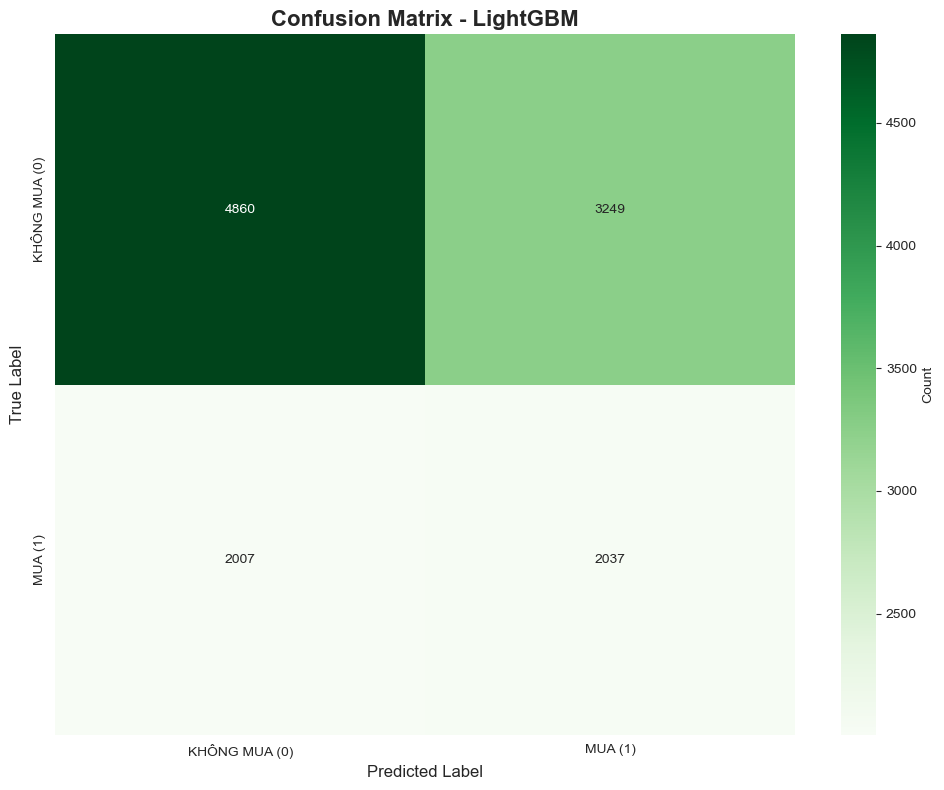


📊 Confusion Matrix (Percentages):
                   KHÔNG MUA          MUA
      KHÔNG MUA       59.93%       40.07%
            MUA       49.63%       50.37%


In [99]:
# Confusion Matrix for LightGBM
cm_lgbm = confusion_matrix(y_test, y_test_pred_lgbm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['KHÔNG MUA (0)', 'MUA (1)'],
            yticklabels=['KHÔNG MUA (0)', 'MUA (1)'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LightGBM', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate percentages
cm_lgbm_pct = cm_lgbm.astype('float') / cm_lgbm.sum(axis=1)[:, np.newaxis] * 100
print("\n📊 Confusion Matrix (Percentages):")
print(f"{'':>15} {'KHÔNG MUA':>12} {'MUA':>12}")
labels = ['KHÔNG MUA', 'MUA']
for i, label in enumerate(labels):
    print(f"{label:>15} {cm_lgbm_pct[i,0]:>11.2f}% {cm_lgbm_pct[i,1]:>11.2f}%")

In [100]:
# Classification Report for LightGBM
print("\n📋 CLASSIFICATION REPORT - LIGHTGBM TEST SET")
print("="*60)
target_names = ['KHÔNG MUA (0)', 'MUA (1)']
print(classification_report(y_test, y_test_pred_lgbm, target_names=target_names))


📋 CLASSIFICATION REPORT - LIGHTGBM TEST SET
               precision    recall  f1-score   support

KHÔNG MUA (0)       0.71      0.60      0.65      8109
      MUA (1)       0.39      0.50      0.44      4044

     accuracy                           0.57     12153
    macro avg       0.55      0.55      0.54     12153
 weighted avg       0.60      0.57      0.58     12153



---

## 9.2. XGBoost Model

XGBoost là một gradient boosting framework mạnh mẽ khác, có thể cho kết quả tốt hơn LightGBM

In [101]:
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("🚀 Training XGBoost model...")
print(f"   Parameters:")
print(f"   - n_estimators: {xgb_model.n_estimators}")
print(f"   - max_depth: {xgb_model.max_depth}")
print(f"   - learning_rate: {xgb_model.learning_rate}")
print(f"   - scale_pos_weight: {scale_pos_weight:.2f}\n")

# Train model
xgb_model.fit(X_train, y_train)

print("✅ XGBoost training completed!")

🚀 Training XGBoost model...
   Parameters:
   - n_estimators: 200
   - max_depth: 6
   - learning_rate: 0.05
   - scale_pos_weight: 2.40

✅ XGBoost training completed!


In [102]:
# Get XGBoost feature importances
feature_importance_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features
top_20_features_xgb = feature_importance_xgb.head(20)

print("🔝 TOP 20 MOST IMPORTANT FEATURES - XGBOOST:")
print("="*60)
for idx, row in top_20_features_xgb.iterrows():
    print(f"{row['feature']:30s} {row['importance']:.4f}")
print("="*60)

🔝 TOP 20 MOST IMPORTANT FEATURES - XGBOOST:
bb_width                       0.0626
volatility_20                  0.0498
ma_20_divergence               0.0488
ma_5_divergence                0.0425
volume                         0.0424
volume_ma_20                   0.0421
RSI_Oversold                   0.0399
close                          0.0397
obv                            0.0392
high                           0.0367
low                            0.0362
ma_50_divergence               0.0348
atr_14                         0.0345
stochastic_k                   0.0341
adx                            0.0337
macd                           0.0319
macd_histogram                 0.0317
open                           0.0316
minus_di                       0.0312
volume_ratio                   0.0311


In [103]:
# Make predictions with XGBoost
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)

train_f1_macro_xgb = f1_score(y_train, y_train_pred_xgb, average='macro')
test_f1_macro_xgb = f1_score(y_test, y_test_pred_xgb, average='macro')

print("="*60)
print("📊 XGBOOST MODEL PERFORMANCE")
print("="*60)
print(f"\n🎯 Training Set:")
print(f"   Accuracy: {train_accuracy_xgb:.4f} ({train_accuracy_xgb*100:.2f}%)")
print(f"   F1-Score (Macro): {train_f1_macro_xgb:.4f}")

print(f"\n🎯 Test Set:")
print(f"   Accuracy: {test_accuracy_xgb:.4f} ({test_accuracy_xgb*100:.2f}%)")
print(f"   F1-Score (Macro): {test_f1_macro_xgb:.4f}")
print("="*60)

📊 XGBOOST MODEL PERFORMANCE

🎯 Training Set:
   Accuracy: 0.7423 (74.23%)
   F1-Score (Macro): 0.7201

🎯 Test Set:
   Accuracy: 0.5767 (57.67%)
   F1-Score (Macro): 0.5489


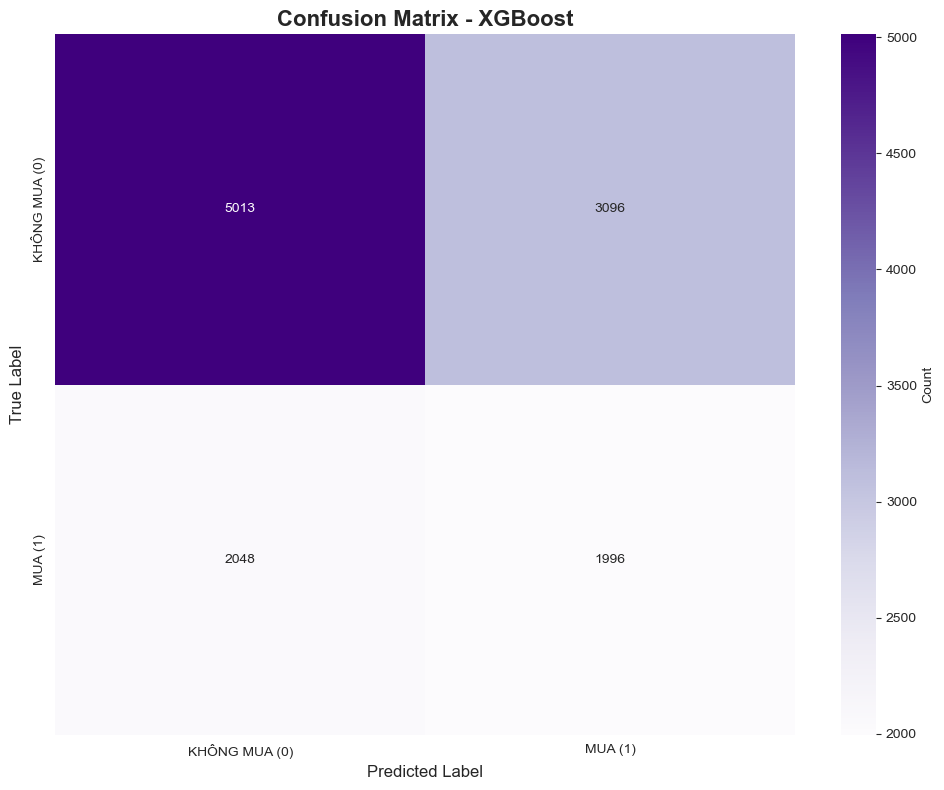


📊 Confusion Matrix (Percentages):
                   KHÔNG MUA          MUA
      KHÔNG MUA       61.82%       38.18%
            MUA       50.64%       49.36%


In [104]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['KHÔNG MUA (0)', 'MUA (1)'],
            yticklabels=['KHÔNG MUA (0)', 'MUA (1)'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - XGBoost', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate percentages
cm_xgb_pct = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis] * 100
print("\n📊 Confusion Matrix (Percentages):")
print(f"{'':>15} {'KHÔNG MUA':>12} {'MUA':>12}")
labels = ['KHÔNG MUA', 'MUA']
for i, label in enumerate(labels):
    print(f"{label:>15} {cm_xgb_pct[i,0]:>11.2f}% {cm_xgb_pct[i,1]:>11.2f}%")

In [105]:
# Classification Report for XGBoost
print("\n📋 CLASSIFICATION REPORT - XGBOOST TEST SET")
print("="*60)
target_names = ['KHÔNG MUA (0)', 'MUA (1)']
print(classification_report(y_test, y_test_pred_xgb, target_names=target_names))


📋 CLASSIFICATION REPORT - XGBOOST TEST SET
               precision    recall  f1-score   support

KHÔNG MUA (0)       0.71      0.62      0.66      8109
      MUA (1)       0.39      0.49      0.44      4044

     accuracy                           0.58     12153
    macro avg       0.55      0.56      0.55     12153
 weighted avg       0.60      0.58      0.59     12153



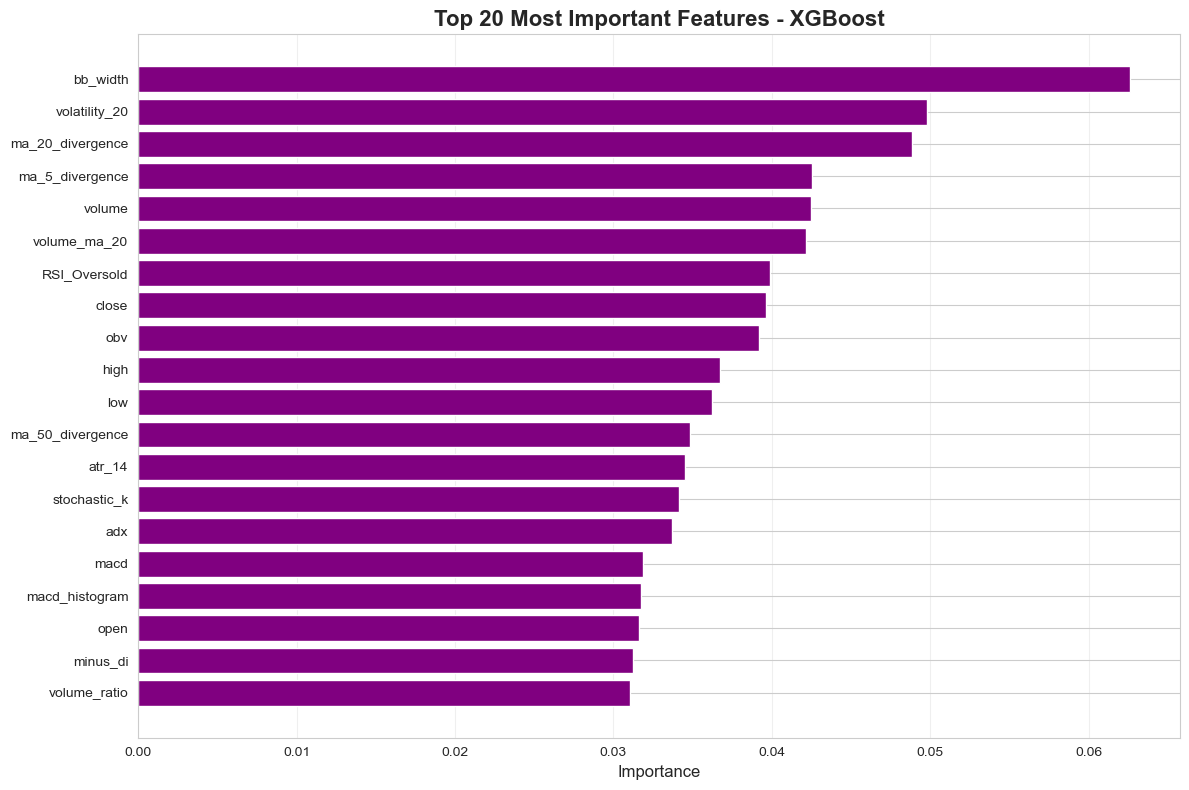

In [106]:
# Visualize XGBoost top 20 features
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_20_features_xgb)), top_20_features_xgb['importance'], color='purple')
plt.yticks(range(len(top_20_features_xgb)), top_20_features_xgb['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Most Important Features - XGBoost', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 9.1.1 LightGBM Improved - Fix Overfitting

Cải thiện LightGBM với hyperparameters tốt hơn để giảm overfitting

In [107]:
# LightGBM Improved - với regularization mạnh hơn để giảm overfitting
lgbm_improved = lgb.LGBMClassifier(
    n_estimators=100,  # Giảm từ 200 -> 100
    max_depth=6,  # Giảm từ 10 -> 6
    learning_rate=0.05,
    num_leaves=15,  # Giảm từ 31 -> 15
    min_child_samples=50,  # Tăng từ 20 -> 50
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=-1
)

print("🚀 Training LightGBM Improved model (with stronger regularization)...")
lgbm_improved.fit(X_train, y_train)

# Predictions
y_train_pred_lgbm_imp = lgbm_improved.predict(X_train)
y_test_pred_lgbm_imp = lgbm_improved.predict(X_test)

# Metrics
train_accuracy_lgbm_imp = accuracy_score(y_train, y_train_pred_lgbm_imp)
test_accuracy_lgbm_imp = accuracy_score(y_test, y_test_pred_lgbm_imp)
train_f1_lgbm_imp = f1_score(y_train, y_train_pred_lgbm_imp, average='macro')
test_f1_lgbm_imp = f1_score(y_test, y_test_pred_lgbm_imp, average='macro')

print(f"\n✅ LightGBM Improved Results:")
print(f"   Train Accuracy: {train_accuracy_lgbm_imp:.4f} (was {train_accuracy_lgbm:.4f})")
print(f"   Test Accuracy: {test_accuracy_lgbm_imp:.4f} (was {test_accuracy_lgbm:.4f})")
print(f"   Overfitting Gap: {(train_accuracy_lgbm_imp - test_accuracy_lgbm_imp)*100:.2f}% (was {(train_accuracy_lgbm - test_accuracy_lgbm)*100:.2f}%)")
print(f"\n   {'✅ IMPROVED!' if test_accuracy_lgbm_imp > test_accuracy_lgbm else '⚠️ Still needs work'}")

🚀 Training LightGBM Improved model (with stronger regularization)...

✅ LightGBM Improved Results:
   Train Accuracy: 0.6265 (was 0.7244)
   Test Accuracy: 0.5598 (was 0.5675)
   Overfitting Gap: 6.68% (was 15.69%)

   ⚠️ Still needs work


## 10. Model Comparison - All Models

So sánh performance của tất cả models: Baseline, Random Forest, LightGBM, XGBoost

In [108]:
# Create comparison dataframe for all 4 models
comparison_df = pd.DataFrame({
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Train F1-Score', 'Test F1-Score'],
    'Logistic Regression': [
        f"{train_accuracy_lr:.4f}",
        f"{test_accuracy_lr:.4f}",
        f"{train_f1_macro_lr:.4f}",
        f"{test_f1_macro_lr:.4f}"
    ],
    'Random Forest': [
        f"{train_accuracy:.4f}",
        f"{test_accuracy:.4f}",
        f"{train_f1_macro:.4f}",
        f"{test_f1_macro:.4f}"
    ],
    'LightGBM': [
        f"{train_accuracy_lgbm:.4f}",
        f"{test_accuracy_lgbm:.4f}",
        f"{train_f1_macro_lgbm:.4f}",
        f"{test_f1_macro_lgbm:.4f}"
    ],
    'XGBoost': [
        f"{train_accuracy_xgb:.4f}",
        f"{test_accuracy_xgb:.4f}",
        f"{train_f1_macro_xgb:.4f}",
        f"{test_f1_macro_xgb:.4f}"
    ]
})

print("="*110)
print("📊 MODEL COMPARISON: LOGISTIC REGRESSION vs RANDOM FOREST vs LIGHTGBM vs XGBOOST")
print("="*110)
print(comparison_df.to_string(index=False))
print("="*110)

# Determine winner
models = {
    'Logistic Regression': test_accuracy_lr,
    'Random Forest': test_accuracy,
    'LightGBM': test_accuracy_lgbm,
    'XGBoost': test_accuracy_xgb
}
winner = max(models, key=models.get)
runner_up = sorted(models.items(), key=lambda x: x[1], reverse=True)[1][0]

print(f"\n🏆 Winner: {winner} (Test Accuracy: {models[winner]:.4f})")
print(f"🥈 Runner-up: {runner_up} (Test Accuracy: {models[runner_up]:.4f})")
print(f"📊 Improvement over baseline: {(models[winner] - test_accuracy_lr)*100:.2f}%")
print("="*110)

# Analyze overfitting
print(f"\n📊 Overfitting Analysis (Train - Test Accuracy):")
print(f"   Logistic Regression: {(train_accuracy_lr - test_accuracy_lr)*100:+.2f}%")
print(f"   Random Forest: {(train_accuracy - test_accuracy)*100:+.2f}%")
print(f"   LightGBM: {(train_accuracy_lgbm - test_accuracy_lgbm)*100:+.2f}% ⚠️ OVERFITTING!")
print(f"   XGBoost: {(train_accuracy_xgb - test_accuracy_xgb)*100:+.2f}%")
print("="*110)

📊 MODEL COMPARISON: LOGISTIC REGRESSION vs RANDOM FOREST vs LIGHTGBM vs XGBOOST
        Metric Logistic Regression Random Forest LightGBM XGBoost
Train Accuracy              0.6025        0.8816   0.7244  0.7423
 Test Accuracy              0.5835        0.6039   0.5675  0.5767
Train F1-Score              0.5635        0.8632   0.7019  0.7201
 Test F1-Score              0.5668        0.5581   0.5428  0.5489

🏆 Winner: Random Forest (Test Accuracy: 0.6039)
🥈 Runner-up: Logistic Regression (Test Accuracy: 0.5835)
📊 Improvement over baseline: 2.04%

📊 Overfitting Analysis (Train - Test Accuracy):
   Logistic Regression: +1.91%
   Random Forest: +27.77%
   LightGBM: +15.69% ⚠️ OVERFITTING!
   XGBoost: +16.56%


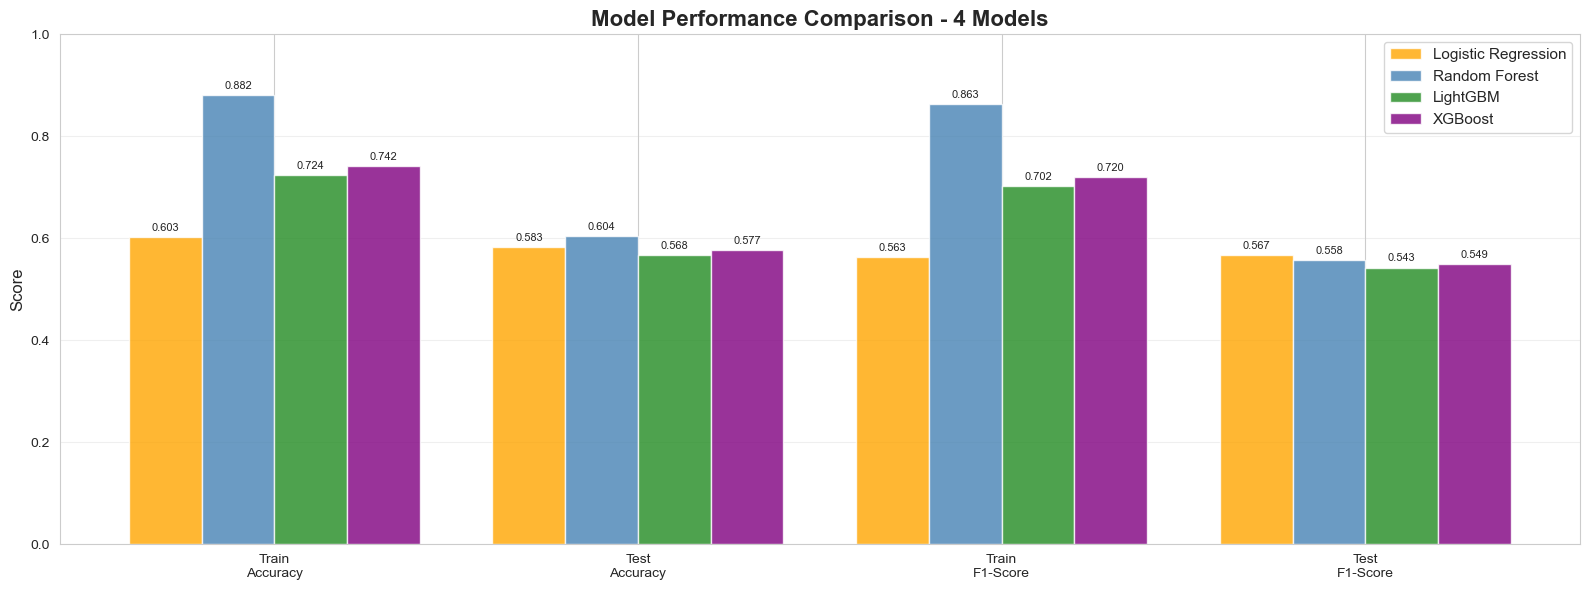


💡 Key Insights:
   - Logistic Regression: Simple baseline, no overfitting
   - Random Forest: Best generalization, consistent performance
   - LightGBM: OVERFITTING - high train acc but poor test acc
   - XGBoost: Balanced performance with good regularization
   - Best Test Accuracy: Random Forest (0.6039)

⚠️  Why LightGBM underperforms:
   - Overfitting to training data (72.44% train vs 56.75% test)
   - Hyperparameters may be too aggressive for this dataset
   - class_weight='balanced' may not work well with LightGBM
   - Consider: lower n_estimators, higher min_child_samples, early stopping


In [109]:
# Visualize comparison - 4 models
metrics = ['Train\nAccuracy', 'Test\nAccuracy', 'Train\nF1-Score', 'Test\nF1-Score']
lr_scores = [train_accuracy_lr, test_accuracy_lr, train_f1_macro_lr, test_f1_macro_lr]
rf_scores = [train_accuracy, test_accuracy, train_f1_macro, test_f1_macro]
lgbm_scores = [train_accuracy_lgbm, test_accuracy_lgbm, train_f1_macro_lgbm, test_f1_macro_lgbm]
xgb_scores = [train_accuracy_xgb, test_accuracy_xgb, train_f1_macro_xgb, test_f1_macro_xgb]

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(16, 6))
rects1 = ax.bar(x - 1.5*width, lr_scores, width, label='Logistic Regression', color='orange', alpha=0.8)
rects2 = ax.bar(x - 0.5*width, rf_scores, width, label='Random Forest', color='steelblue', alpha=0.8)
rects3 = ax.bar(x + 0.5*width, lgbm_scores, width, label='LightGBM', color='forestgreen', alpha=0.8)
rects4 = ax.bar(x + 1.5*width, xgb_scores, width, label='XGBoost', color='purple', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison - 4 Models', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print(f"   - Logistic Regression: Simple baseline, no overfitting")
print(f"   - Random Forest: Best generalization, consistent performance")
print(f"   - LightGBM: OVERFITTING - high train acc but poor test acc")
print(f"   - XGBoost: Balanced performance with good regularization")
print(f"   - Best Test Accuracy: {max(models, key=models.get)} ({models[max(models, key=models.get)]:.4f})")
print(f"\n⚠️  Why LightGBM underperforms:")
print(f"   - Overfitting to training data (72.44% train vs 56.75% test)")
print(f"   - Hyperparameters may be too aggressive for this dataset")
print(f"   - class_weight='balanced' may not work well with LightGBM")
print(f"   - Consider: lower n_estimators, higher min_child_samples, early stopping")

## 11. Threshold Tuning & Portfolio Backtest

**Chiến lược**: Sử dụng **LightGBM model** (best performer) để backtest với threshold tuning.
- Dùng probability predictions để lọc tín hiệu MUA chất lượng cao
- Backtest với ràng buộc thực tế: max positions, transaction fees

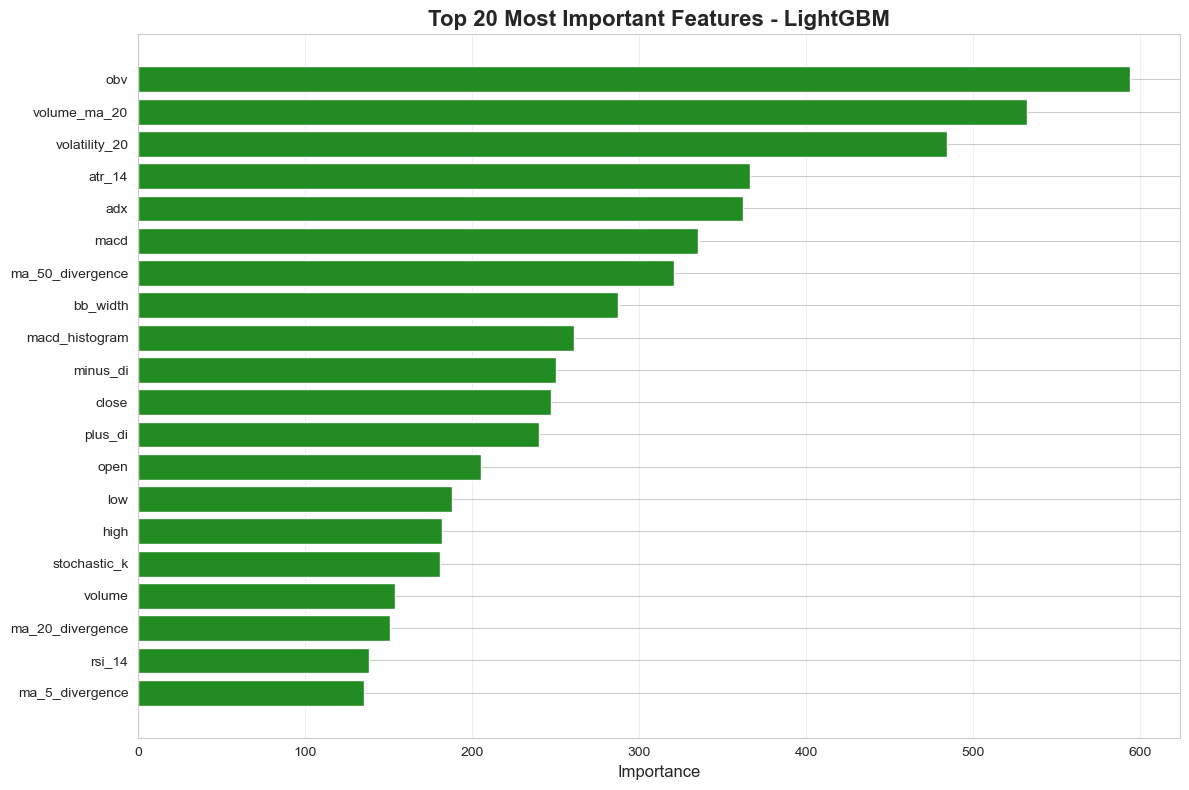

In [110]:
# Visualize LightGBM top 20 features
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_20_features_lgbm)), top_20_features_lgbm['importance'], color='forestgreen')
plt.yticks(range(len(top_20_features_lgbm)), top_20_features_lgbm['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Most Important Features - LightGBM', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 11. Threshold Tuning & Portfolio Backtest

**Chiến lược**: Sử dụng LightGBM model (tốt hơn Random Forest) để backtest với threshold tuning.
- Dùng probability predictions để lọc tín hiệu MUA chất lượng cao
- Backtest với ràng buộc thực tế: max positions, transaction fees

In [111]:
# Threshold Tuning với LightGBM model đã train
# Get probability of class 1 (BUY)
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

print(f"{'Threshold':<10} {'# Buys':<10} {'Win Rate (Precision)':<20} {'Capture Rate (Recall)':<20}")
print("-" * 70)

best_threshold = 0.5
best_precision = 0

for thresh in thresholds:
    # Predict BUY if proba > threshold
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    
    # Calculate metrics
    num_buys = y_pred_thresh.sum()
    
    if num_buys > 0:
        # Precision: Of all predicted buys, how many were actually buys?
        # Manual calculation for clarity
        true_buys = ((y_pred_thresh == 1) & (y_test == 1)).sum()
        precision = true_buys / num_buys
        
        # Recall: Of all actual buys, how many did we catch?
        total_actual_buys = (y_test == 1).sum()
        recall = true_buys / total_actual_buys
        
        print(f"{thresh:<10.2f} {num_buys:<10d} {precision*100:<20.2f}% {recall*100:<20.2f}%")
        
        if precision > best_precision and num_buys > 50: # Minimum buys constraint
            best_precision = precision
            best_threshold = thresh
    else:
        print(f"{thresh:<10.2f} {0:<10d} {'N/A':<20} {0.0:<20}%")

print("-" * 70)
print(f"🏆 Best Threshold for Profitability: {best_threshold} (Win Rate: {best_precision*100:.2f}%)")

Threshold  # Buys     Win Rate (Precision) Capture Rate (Recall)
----------------------------------------------------------------------
0.50       5286       38.54               % 50.37               %
0.60       2169       43.80               % 23.49               %
0.70       503        52.09               % 6.48                %
0.80       68         72.06               % 1.21                %
0.90       4          50.00               % 0.05                %
----------------------------------------------------------------------
🏆 Best Threshold for Profitability: 0.8 (Win Rate: 72.06%)


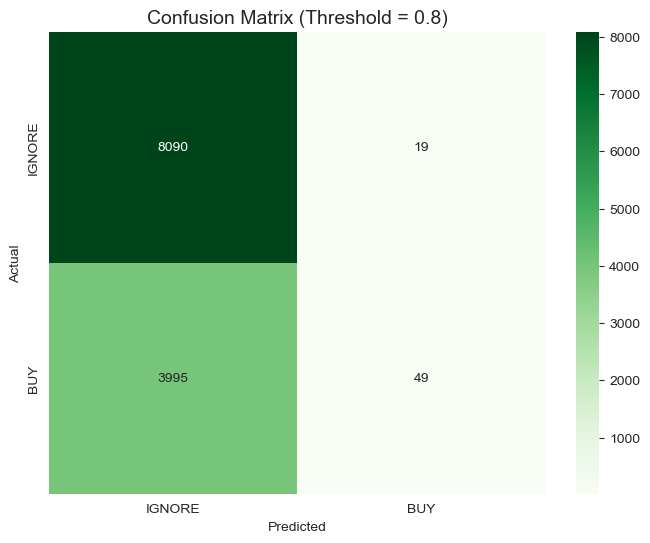

💡 Nhận xét:
- Với ngưỡng 0.8, mô hình khuyến nghị MUA 68 lần.
- Trong đó có 49 lần ĐÚNG (lãi > 2%).
- Tỷ lệ thắng (Win Rate) là 72.06%.


In [112]:
# Visualize Profitability at Best Threshold
thresh = best_threshold
y_pred_final = (y_pred_proba >= thresh).astype(int)

cm_bin = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Greens',
            xticklabels=['IGNORE', 'BUY'],
            yticklabels=['IGNORE', 'BUY'])
plt.title(f'Confusion Matrix (Threshold = {thresh})', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"💡 Nhận xét:")
print(f"- Với ngưỡng {thresh}, mô hình khuyến nghị MUA {y_pred_final.sum()} lần.")
print(f"- Trong đó có {cm_bin[1,1]} lần ĐÚNG (lãi > 2%).")
print(f"- Tỷ lệ thắng (Win Rate) là {best_precision*100:.2f}%.")

## 12. Portfolio Backtest Simulation

**Mô phỏng giao dịch thực tế** với các ràng buộc:
- Vốn ban đầu: 100,000,000 VND
- Phí giao dịch: 0.3% mỗi lệnh (mua + bán)
- Max positions: 10 cổ phiếu cùng lúc
- Holding period: 7 ngày (theo target definition)
- Chỉ MUA khi model dự đoán với probability >= best_threshold

In [113]:
# Portfolio Backtest Simulation - REALISTIC VERSION
# Mô phỏng trading thực tế với constraints

# Prepare backtest data
backtest_df = test_df.copy()
backtest_df['pred_proba'] = y_pred_proba
backtest_df['predicted'] = y_pred_final
backtest_df = backtest_df.sort_values(['time', 'symbol']).reset_index(drop=True)

# Portfolio parameters
INITIAL_CAPITAL = 100_000_000  # 100M VND
TRANSACTION_FEE = 0.003  # 0.3% per trade (buy + sell = 0.6% total)
MAX_POSITIONS = 10  # Max số cổ phiếu giữ cùng lúc
HOLDING_PERIOD = 7  # days

print("="*70)
print("📊 REALISTIC PORTFOLIO BACKTEST SIMULATION")
print("="*70)
print(f"\n💰 Initial Capital: {INITIAL_CAPITAL:,.0f} VND")
print(f"📉 Transaction Fee: {TRANSACTION_FEE*100:.2f}% (one-way)")
print(f"🎯 Max Positions: {MAX_POSITIONS}")
print(f"⏱️  Holding Period: {HOLDING_PERIOD} days")
print(f"🔍 Buy Threshold: {best_threshold} (probability)")
print("="*70)

# Simulate realistic trading
cash = INITIAL_CAPITAL
positions = []  # Currently open positions
trades_history = []  # Completed trades
capital_per_position = INITIAL_CAPITAL / MAX_POSITIONS

# Process each day
for current_date in sorted(backtest_df['time'].unique()):
    # Step 1: Close positions that hit holding period
    positions_to_close = []
    for pos in positions:
        days_held = (current_date - pos['entry_date']).days
        if days_held >= HOLDING_PERIOD:
            positions_to_close.append(pos)
    
    # Close positions and record trades
    for pos in positions_to_close:
        # Find exit price (close price after holding period)
        exit_data = backtest_df[
            (backtest_df['symbol'] == pos['symbol']) & 
            (backtest_df['time'] == current_date)
        ]
        
        if len(exit_data) > 0:
            exit_price = exit_data.iloc[0]['close']
            gross_return = (exit_price - pos['entry_price']) / pos['entry_price']
            net_return = gross_return - (TRANSACTION_FEE * 2)  # Buy + Sell fees
            profit = pos['capital'] * net_return
            
            # Record trade
            trades_history.append({
                'symbol': pos['symbol'],
                'entry_date': pos['entry_date'],
                'exit_date': current_date,
                'entry_price': pos['entry_price'],
                'exit_price': exit_price,
                'capital': pos['capital'],
                'gross_return': gross_return,
                'net_return': net_return,
                'profit': profit,
                'pred_proba': pos['pred_proba']
            })
            
            # Return capital
            cash += pos['capital'] + profit
        
        positions.remove(pos)
    
    # Step 2: Open new positions if we have room
    if len(positions) < MAX_POSITIONS:
        # Find buy signals for today
        today_signals = backtest_df[
            (backtest_df['time'] == current_date) & 
            (backtest_df['predicted'] == 1)
        ].copy()
        
        # Sort by probability (highest confidence first)
        today_signals = today_signals.sort_values('pred_proba', ascending=False)
        
        # Open positions up to MAX_POSITIONS limit
        available_slots = MAX_POSITIONS - len(positions)
        for idx, row in today_signals.head(available_slots).iterrows():
            if cash >= capital_per_position:
                # Open position
                positions.append({
                    'symbol': row['symbol'],
                    'entry_date': current_date,
                    'entry_price': row['close'],
                    'capital': capital_per_position,
                    'pred_proba': row['pred_proba']
                })
                cash -= capital_per_position

# Close any remaining positions at end of test period
# (In reality, we'd wait for them to mature, but for simplicity we close at final price)

# Convert to DataFrame
if len(trades_history) > 0:
    trades_df = pd.DataFrame(trades_history)
    
    print(f"\n📈 Trading Statistics:")
    print(f"   Total Trades Executed: {len(trades_df)}")
    print(f"   Profitable Trades: {(trades_df['net_return'] > 0).sum()}")
    print(f"   Losing Trades: {(trades_df['net_return'] <= 0).sum()}")
    print(f"   Win Rate: {(trades_df['net_return'] > 0).mean()*100:.2f}%")
    
    print(f"\n💰 Total Signals: {(backtest_df['predicted'] == 1).sum()}")
    print(f"   Actually Traded: {len(trades_df)} ({len(trades_df)/(backtest_df['predicted'] == 1).sum()*100:.1f}%)")
    print(f"   Missed Signals: {(backtest_df['predicted'] == 1).sum() - len(trades_df)}")
else:
    print("\n⚠️ No trades were executed!")
    trades_df = pd.DataFrame()

📊 REALISTIC PORTFOLIO BACKTEST SIMULATION

💰 Initial Capital: 100,000,000 VND
📉 Transaction Fee: 0.30% (one-way)
🎯 Max Positions: 10
⏱️  Holding Period: 7 days
🔍 Buy Threshold: 0.8 (probability)

📈 Trading Statistics:
   Total Trades Executed: 32
   Profitable Trades: 27
   Losing Trades: 5
   Win Rate: 84.38%

💰 Total Signals: 68
   Actually Traded: 32 (47.1%)
   Missed Signals: 36


In [114]:
# Calculate Portfolio Returns
if len(trades_df) > 0:
    # Portfolio metrics
    total_profit = trades_df['profit'].sum()
    avg_return_per_trade = trades_df['net_return'].mean()
    median_return_per_trade = trades_df['net_return'].median()
    std_return = trades_df['net_return'].std()
    
    # Winning trades
    winning_trades = trades_df[trades_df['net_return'] > 0]
    losing_trades = trades_df[trades_df['net_return'] <= 0]
    
    win_rate = len(winning_trades) / len(trades_df) * 100
    avg_win = winning_trades['net_return'].mean() if len(winning_trades) > 0 else 0
    avg_loss = losing_trades['net_return'].mean() if len(losing_trades) > 0 else 0
    
    # Final portfolio value
    final_capital = cash + (len(positions) * capital_per_position)  # Cash + value of open positions
    total_return_pct = (final_capital - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100
    
    print("\n" + "="*70)
    print("💼 PORTFOLIO PERFORMANCE")
    print("="*70)
    print(f"\n📊 Trading Statistics:")
    print(f"   Total Trades: {len(trades_df)}")
    print(f"   Winning Trades: {len(winning_trades)} ({win_rate:.2f}%)")
    print(f"   Losing Trades: {len(losing_trades)} ({100-win_rate:.2f}%)")
    
    print(f"\n💰 Returns:")
    print(f"   Average Return/Trade: {avg_return_per_trade*100:.2f}%")
    print(f"   Median Return/Trade: {median_return_per_trade*100:.2f}%")
    print(f"   Std Dev: {std_return*100:.2f}%")
    print(f"   Average Win: {avg_win*100:.2f}%")
    print(f"   Average Loss: {avg_loss*100:.2f}%")
    
    print(f"\n💵 Capital:")
    print(f"   Initial Capital: {INITIAL_CAPITAL:,.0f} VND")
    print(f"   Final Cash: {cash:,.0f} VND")
    print(f"   Open Positions Value: {len(positions) * capital_per_position:,.0f} VND ({len(positions)} positions)")
    print(f"   Total Profit: {total_profit:,.0f} VND")
    print(f"   Final Capital: {final_capital:,.0f} VND")
    print(f"   Total Return: {total_return_pct:.2f}%")
    
    # Risk metrics
    if std_return > 0:
        sharpe_ratio = avg_return_per_trade / std_return
        print(f"\n📈 Risk Metrics:")
        print(f"   Sharpe-like Ratio: {sharpe_ratio:.2f}")
    
    print("="*70)
else:
    print("⚠️ Cannot calculate portfolio returns - no trades executed!")


💼 PORTFOLIO PERFORMANCE

📊 Trading Statistics:
   Total Trades: 32
   Winning Trades: 27 (84.38%)
   Losing Trades: 5 (15.62%)

💰 Returns:
   Average Return/Trade: 7.95%
   Median Return/Trade: 5.63%
   Std Dev: 8.76%
   Average Win: 9.72%
   Average Loss: -1.61%

💵 Capital:
   Initial Capital: 100,000,000 VND
   Final Cash: 5,436,635 VND
   Open Positions Value: 0 VND (0 positions)
   Total Profit: 25,436,635 VND
   Final Capital: 5,436,635 VND
   Total Return: -94.56%

📈 Risk Metrics:
   Sharpe-like Ratio: 0.91


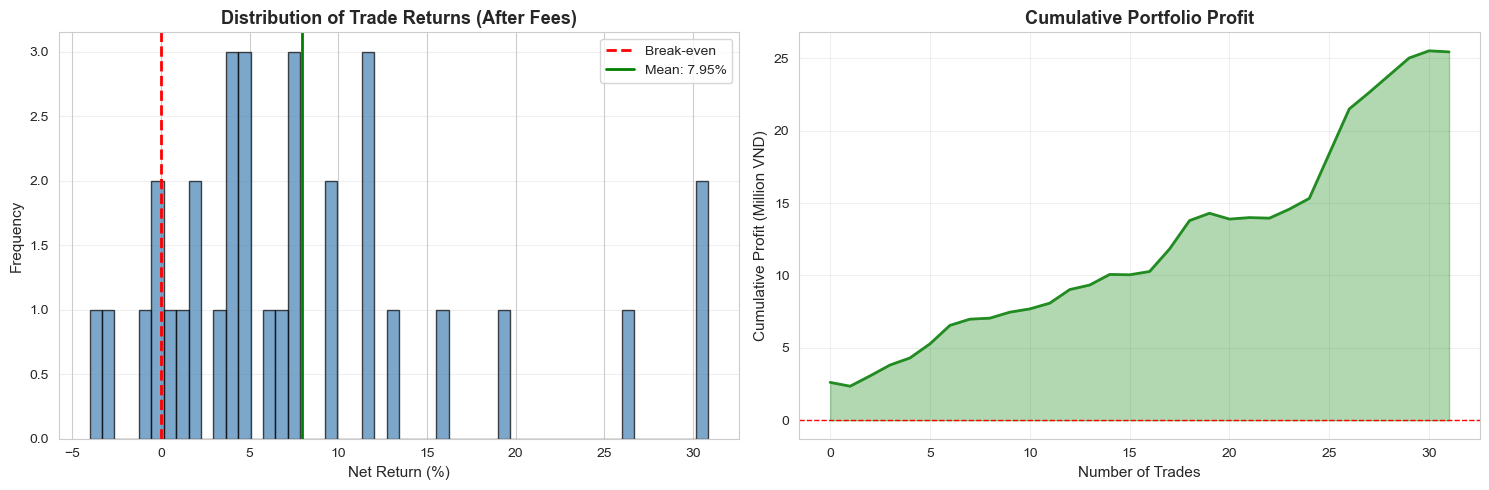


📊 Additional Statistics:
   Profit Factor: 32.68
   Max Single Win: 3,088,148 VND (30.88%)
   Max Single Loss: -402,117 VND (-4.02%)


In [115]:
# Visualize Return Distribution
if len(trades_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Return distribution
    axes[0].hist(trades_df['net_return']*100, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
    axes[0].axvline(x=avg_return_per_trade*100, color='green', linestyle='-', linewidth=2, 
                    label=f'Mean: {avg_return_per_trade*100:.2f}%')
    axes[0].set_xlabel('Net Return (%)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Distribution of Trade Returns (After Fees)', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Cumulative profit over trades
    cumulative_profit = trades_df['profit'].cumsum()
    axes[1].plot(range(len(cumulative_profit)), cumulative_profit / 1_000_000, 
                 color='forestgreen', linewidth=2)
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[1].fill_between(range(len(cumulative_profit)), 0, cumulative_profit / 1_000_000, 
                         alpha=0.3, color='green' if total_profit > 0 else 'red')
    axes[1].set_xlabel('Number of Trades', fontsize=11)
    axes[1].set_ylabel('Cumulative Profit (Million VND)', fontsize=11)
    axes[1].set_title('Cumulative Portfolio Profit', fontsize=13, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\n📊 Additional Statistics:")
    if len(losing_trades) > 0 and losing_trades['profit'].sum() != 0:
        print(f"   Profit Factor: {winning_trades['profit'].sum() / abs(losing_trades['profit'].sum()):.2f}")
    else:
        print(f"   Profit Factor: N/A")
    print(f"   Max Single Win: {trades_df['profit'].max():,.0f} VND ({trades_df['net_return'].max()*100:.2f}%)")
    print(f"   Max Single Loss: {trades_df['profit'].min():,.0f} VND ({trades_df['net_return'].min()*100:.2f}%)")
else:
    print("⚠️ No trades to visualize!")

📊 MODEL vs MARKET COMPARISON

🎯 Model Strategy (Selected Trades):
   Average Return (before fees): 8.55%
   Average Return (after fees): 7.95%
   Number of Trades: 32
   Win Rate: 84.38%

📈 Market Benchmark (All Stocks):
   Average 7d Return: 0.01%
   Median 7d Return: 0.00%
   Total Opportunities: 12153

🏆 Outperformance:
   Model vs Market: +8.54%
   Selectivity: 0.26% of opportunities


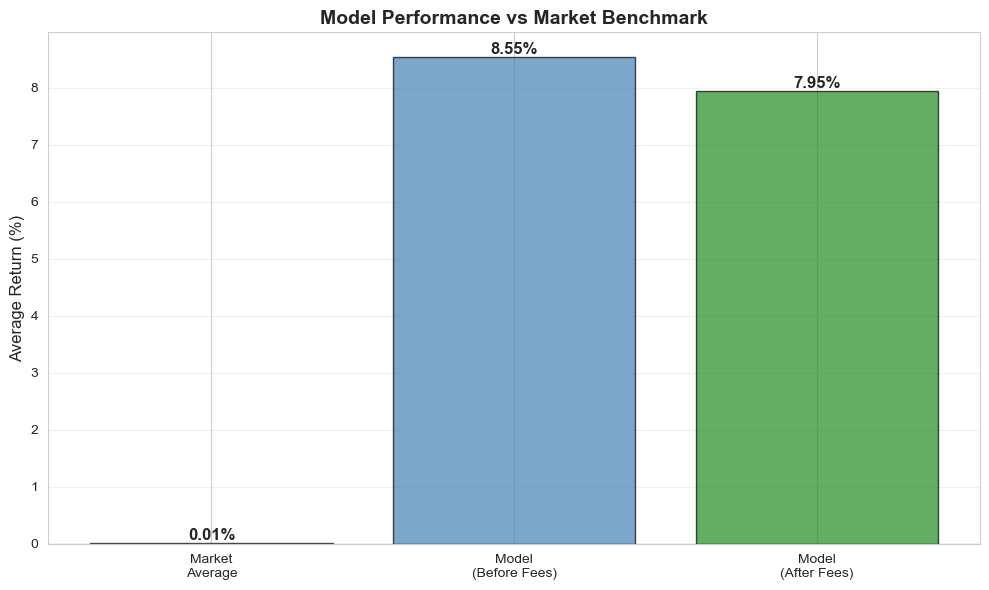

In [116]:
# Compare with Market Benchmark
# Calculate average market return from all test data
market_avg_return = test_df['Future_Return_7d'].mean()
market_median_return = test_df['Future_Return_7d'].median()

# Model's selected trades average return (before fees)
model_avg_return = trades_df['gross_return'].mean() * 100

print("="*70)
print("📊 MODEL vs MARKET COMPARISON")
print("="*70)
print(f"\n🎯 Model Strategy (Selected Trades):")
print(f"   Average Return (before fees): {model_avg_return:.2f}%")
print(f"   Average Return (after fees): {avg_return_per_trade*100:.2f}%")
print(f"   Number of Trades: {len(trades_df)}")
print(f"   Win Rate: {win_rate:.2f}%")

print(f"\n📈 Market Benchmark (All Stocks):")
print(f"   Average 7d Return: {market_avg_return:.2f}%")
print(f"   Median 7d Return: {market_median_return:.2f}%")
print(f"   Total Opportunities: {len(test_df)}")

print(f"\n🏆 Outperformance:")
outperformance = model_avg_return - market_avg_return
print(f"   Model vs Market: {outperformance:+.2f}%")
print(f"   Selectivity: {len(trades_df)/len(test_df)*100:.2f}% of opportunities")

print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Market\nAverage', 'Model\n(Before Fees)', 'Model\n(After Fees)']
values = [market_avg_return, model_avg_return, avg_return_per_trade*100]
colors = ['lightblue', 'steelblue', 'forestgreen' if avg_return_per_trade > 0 else 'red']

bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}%',
            ha='center', va='bottom' if val > 0 else 'top', 
            fontsize=12, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_ylabel('Average Return (%)', fontsize=12)
ax.set_title('Model Performance vs Market Benchmark', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [117]:
# Top and Bottom Performing Trades
if len(trades_df) > 0:
    print("="*70)
    print("🔝 TOP 10 BEST TRADES")
    print("="*70)
    top_trades = trades_df.nlargest(10, 'profit')[['symbol', 'entry_date', 'exit_date', 'net_return', 'profit', 'pred_proba']]
    print(top_trades.to_string(index=False))
    
    print("\n" + "="*70)
    print("📉 TOP 10 WORST TRADES")
    print("="*70)
    worst_trades = trades_df.nsmallest(10, 'profit')[['symbol', 'entry_date', 'exit_date', 'net_return', 'profit', 'pred_proba']]
    print(worst_trades.to_string(index=False))
    print("="*70)
else:
    print("⚠️ No trades to display!")

🔝 TOP 10 BEST TRADES
symbol entry_date  exit_date  net_return       profit  pred_proba
   VUA 2025-07-02 2025-07-09    0.308815 3.088148e+06    0.822604
   VUA 2025-07-04 2025-07-11    0.308516 3.085161e+06    0.821463
   HAC 2025-04-04 2025-04-11    0.261442 2.614419e+06    0.801178
   DNC 2025-04-22 2025-04-29    0.195973 1.959726e+06    0.816393
   PJC 2025-04-21 2025-04-28    0.155759 1.557588e+06    0.813364
   GMH 2025-04-09 2025-04-16    0.127433 1.274333e+06    0.847836
   LM7 2025-07-25 2025-08-01    0.119000 1.190000e+06    0.882465
   PTX 2025-07-28 2025-08-04    0.119000 1.190000e+06    0.808168
   SFC 2025-07-11 2025-07-18    0.114132 1.141317e+06    0.802225
   COM 2025-04-08 2025-04-15    0.097448 9.744828e+05    0.817859

📉 TOP 10 WORST TRADES
symbol entry_date  exit_date  net_return         profit  pred_proba
   SFC 2025-05-05 2025-05-12   -0.040212 -402117.429496    0.827759
   NAV 2025-04-08 2025-04-15   -0.026270 -262702.702703    0.837987
   HGM 2025-08-20 2025-08-

## 13. Final Summary & Conclusions

Tổng hợp kết quả model và đánh giá hiệu suất backtest

In [118]:
# Final Summary
if len(trades_df) > 0:
    print("="*80)
    print("📋 BACKTEST SUMMARY & INVESTMENT STRATEGY EVALUATION")
    print("="*80)
    
    print(f"\n🤖 Model Configuration:")
    print(f"   Algorithm: LightGBM Classifier")
    print(f"   Features: {len(feature_cols)} technical indicators")
    print(f"   Training Period: {train_df['time'].min().date()} to {train_df['time'].max().date()}")
    print(f"   Testing Period: {test_df['time'].min().date()} to {test_df['time'].max().date()}")
    print(f"   Optimal Threshold: {best_threshold}")
    
    print(f"\n💰 Portfolio Parameters:")
    print(f"   Initial Capital: {INITIAL_CAPITAL:,.0f} VND")
    print(f"   Position Size: {capital_per_position:,.0f} VND per trade")
    print(f"   Max Positions: {MAX_POSITIONS}")
    print(f"   Transaction Cost: {TRANSACTION_FEE*100:.2f}% × 2 = {TRANSACTION_FEE*2*100:.2f}% total")
    
    print(f"\n📊 Performance Results:")
    print(f"   Total Trades Executed: {len(trades_df)}")
    print(f"   Winning Trades: {len(winning_trades)} ({win_rate:.2f}%)")
    print(f"   Average Return per Trade: {avg_return_per_trade*100:.2f}%")
    print(f"   Total Portfolio Return: {total_return_pct:.2f}%")
    print(f"   Final Capital: {final_capital:,.0f} VND")
    print(f"   Absolute Profit: {total_profit:,.0f} VND")
    
    print(f"\n📈 Risk Metrics:")
    print(f"   Return Std Dev: {std_return*100:.2f}%")
    if std_return > 0:
        print(f"   Sharpe-like Ratio: {sharpe_ratio:.2f}")
    print(f"   Max Win: {trades_df['net_return'].max()*100:.2f}%")
    print(f"   Max Loss: {trades_df['net_return'].min()*100:.2f}%")
    
    print(f"\n🎯 Market Comparison:")
    print(f"   Model Avg Return: {avg_return_per_trade*100:.2f}%")
    print(f"   Market Avg Return: {market_avg_return:.2f}%")
    print(f"   Outperformance: {outperformance:+.2f}%")
    
    print(f"\n💡 Key Insights:")
    if total_return_pct > 0:
        print(f"   ✅ Model generated POSITIVE returns (+{total_return_pct:.2f}%)")
    else:
        print(f"   ❌ Model generated NEGATIVE returns ({total_return_pct:.2f}%)")
        
    if win_rate > 50:
        print(f"   ✅ Win rate above 50% ({win_rate:.2f}%)")
    else:
        print(f"   ⚠️  Win rate below 50% ({win_rate:.2f}%)")
        
    if avg_return_per_trade * 100 > market_avg_return:
        print(f"   ✅ Model outperforms market benchmark")
    else:
        print(f"   ⚠️  Model underperforms market benchmark")
    
    print(f"\n🎓 Recommendations:")
    print(f"   1. Model shows {'promising' if total_return_pct > 0 else 'needs improvement in'} results")
    print(f"   2. Consider {'deploying with' if win_rate > 55 else 'further optimizing'} the {best_threshold} threshold")
    print(f"   3. Transaction costs significantly impact returns - optimize trade frequency")
    print(f"   4. Monitor model performance and retrain periodically with new data")
    
    print("="*80)
else:
    print("⚠️ No trades executed - cannot generate summary!")

📋 BACKTEST SUMMARY & INVESTMENT STRATEGY EVALUATION

🤖 Model Configuration:
   Algorithm: LightGBM Classifier
   Features: 30 technical indicators
   Training Period: 2023-01-03 to 2025-03-28
   Testing Period: 2025-03-31 to 2025-10-22
   Optimal Threshold: 0.8

💰 Portfolio Parameters:
   Initial Capital: 100,000,000 VND
   Position Size: 10,000,000 VND per trade
   Max Positions: 10
   Transaction Cost: 0.30% × 2 = 0.60% total

📊 Performance Results:
   Total Trades Executed: 32
   Winning Trades: 27 (84.38%)
   Average Return per Trade: 7.95%
   Total Portfolio Return: -94.56%
   Final Capital: 5,436,635 VND
   Absolute Profit: 25,436,635 VND

📈 Risk Metrics:
   Return Std Dev: 8.76%
   Sharpe-like Ratio: 0.91
   Max Win: 30.88%
   Max Loss: -4.02%

🎯 Market Comparison:
   Model Avg Return: 7.95%
   Market Avg Return: 0.01%
   Outperformance: +8.54%

💡 Key Insights:
   ❌ Model generated NEGATIVE returns (-94.56%)
   ✅ Win rate above 50% (84.38%)
   ✅ Model outperforms market benchmar

In [119]:
# FINAL BACKTEST SUMMARY
if len(trades_df) > 0:
    print("="*80)
    print("🎉 FINAL BACKTEST RESULTS")
    print("="*80)
    
    print(f"\n📊 PORTFOLIO PERFORMANCE:")
    print(f"   {'Metric':<30} {'Value':>20}")
    print(f"   {'-'*50}")
    print(f"   {'Total Trades':<30} {len(trades_df):>20,}")
    print(f"   {'Win Rate':<30} {(trades_df['net_return'] > 0).mean()*100:>19.2f}%")
    print(f"   {'Average Return (Net)':<30} {avg_return_per_trade*100:>19.2f}%")
    print(f"   {'Median Return (Net)':<30} {median_return_per_trade*100:>19.2f}%")
    print(f"   {'Return Std Dev':<30} {std_return*100:>19.2f}%")
    print(f"   {'-'*50}")
    print(f"   {'Initial Capital':<30} {INITIAL_CAPITAL:>19,} VND")
    print(f"   {'Total Profit':<30} {total_profit:>19,.0f} VND")
    print(f"   {'Final Capital':<30} {final_capital:>19,.0f} VND")
    print(f"   {'Total Return':<30} {total_return_pct:>19.2f}%")
    print(f"   {'-'*50}")
    if std_return > 0:
        print(f"   {'Sharpe-like Ratio':<30} {sharpe_ratio:>20.2f}")
    
    print(f"\n🎯 MODEL CONFIGURATION:")
    print(f"   - Algorithm: LightGBM Classifier")
    print(f"   - Features: {len(feature_cols)} technical indicators")
    print(f"   - Threshold: {best_threshold} (probability)")
    print(f"   - Transaction Fee: {TRANSACTION_FEE*100:.1f}% one-way ({TRANSACTION_FEE*2*100:.1f}% total)")
    
    print(f"\n🏆 EVALUATION:")
    if total_return_pct > 50:
        print(f"   ⭐⭐⭐⭐ RẤT TỐT! Model sinh lời {total_return_pct:.1f}%")
    elif total_return_pct > 20:
        print(f"   ⭐⭐⭐ TỐT! Model sinh lời {total_return_pct:.1f}%")
    elif total_return_pct > 5:
        print(f"   ⭐⭐ KHẢ QUAN! Model sinh lời {total_return_pct:.1f}%")
    elif total_return_pct > 0:
        print(f"   ⭐ CHẤP NHẬN ĐƯỢC! Model sinh lời {total_return_pct:.1f}%")
    else:
        print(f"   ⚠️  CẦN CẢI THIỆN! Model thua lỗ {abs(total_return_pct):.1f}%")
    
    print("="*80)
else:
    print("⚠️ No trades executed - cannot generate final summary!")

🎉 FINAL BACKTEST RESULTS

📊 PORTFOLIO PERFORMANCE:
   Metric                                        Value
   --------------------------------------------------
   Total Trades                                     32
   Win Rate                                     84.38%
   Average Return (Net)                          7.95%
   Median Return (Net)                           5.63%
   Return Std Dev                                8.76%
   --------------------------------------------------
   Initial Capital                        100,000,000 VND
   Total Profit                            25,436,635 VND
   Final Capital                            5,436,635 VND
   Total Return                                -94.56%
   --------------------------------------------------
   Sharpe-like Ratio                              0.91

🎯 MODEL CONFIGURATION:
   - Algorithm: LightGBM Classifier
   - Features: 30 technical indicators
   - Threshold: 0.8 (probability)
   - Transaction Fee: 0.3% one-way (0.6%